### Modelo de Generación Solar

El objetivo de este modelo es predecir la generación solar nacional diaria (`Gen_Solar_GWh`) a partir de una serie temporal histórica. La generación solar presenta una fuerte estacionalidad anual y semanal, así como posibles tendencias derivadas de la evolución del parque fotovoltaico y de factores climáticos, lo que justifica el uso de un modelo específico de series temporales.

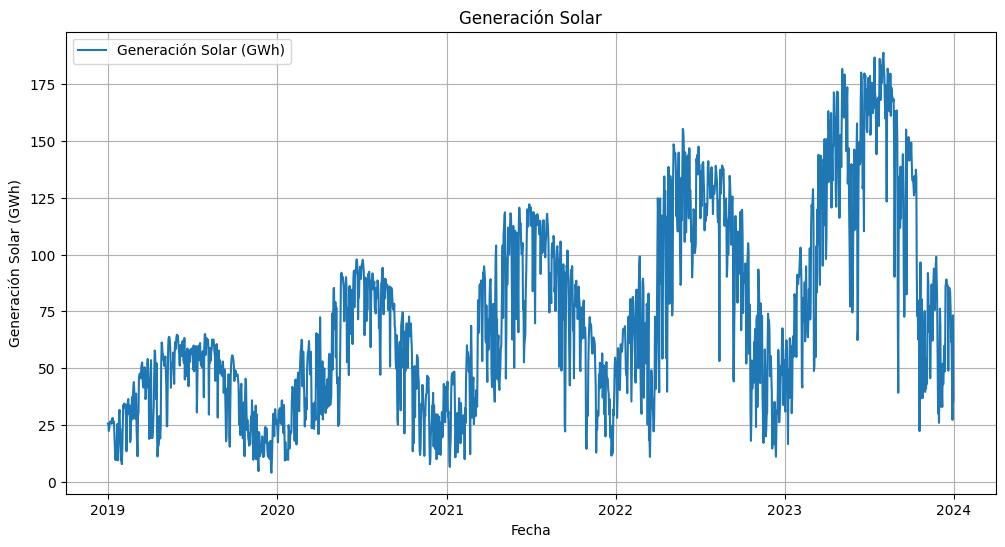

13:42:15 - cmdstanpy - INFO - Chain [1] start processing
13:42:15 - cmdstanpy - INFO - Chain [1] done processing


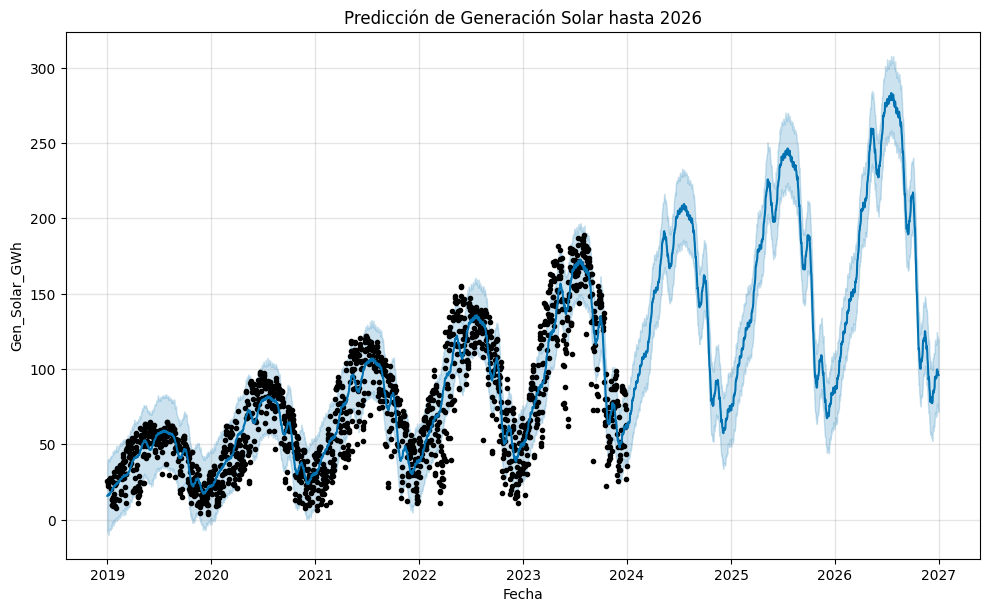

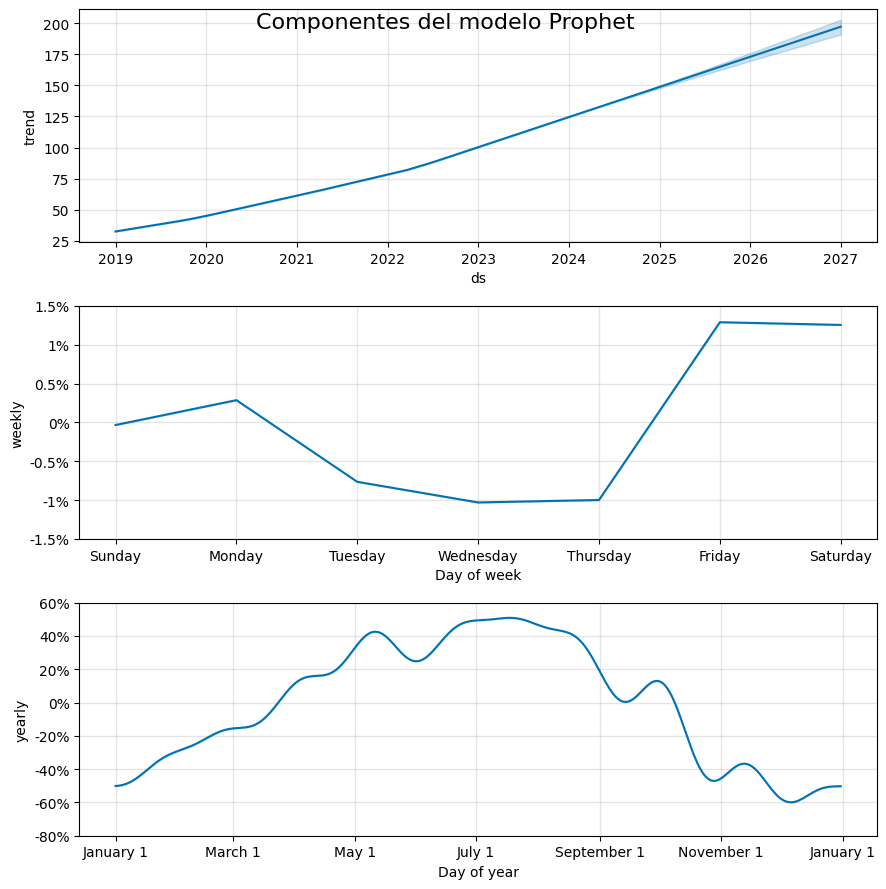

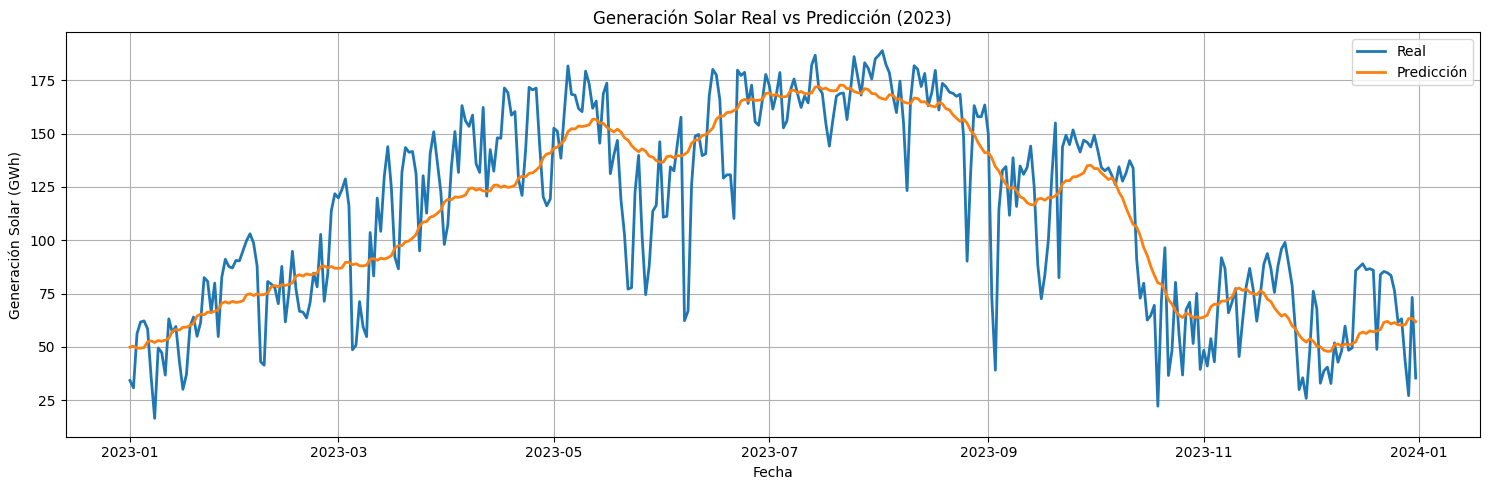

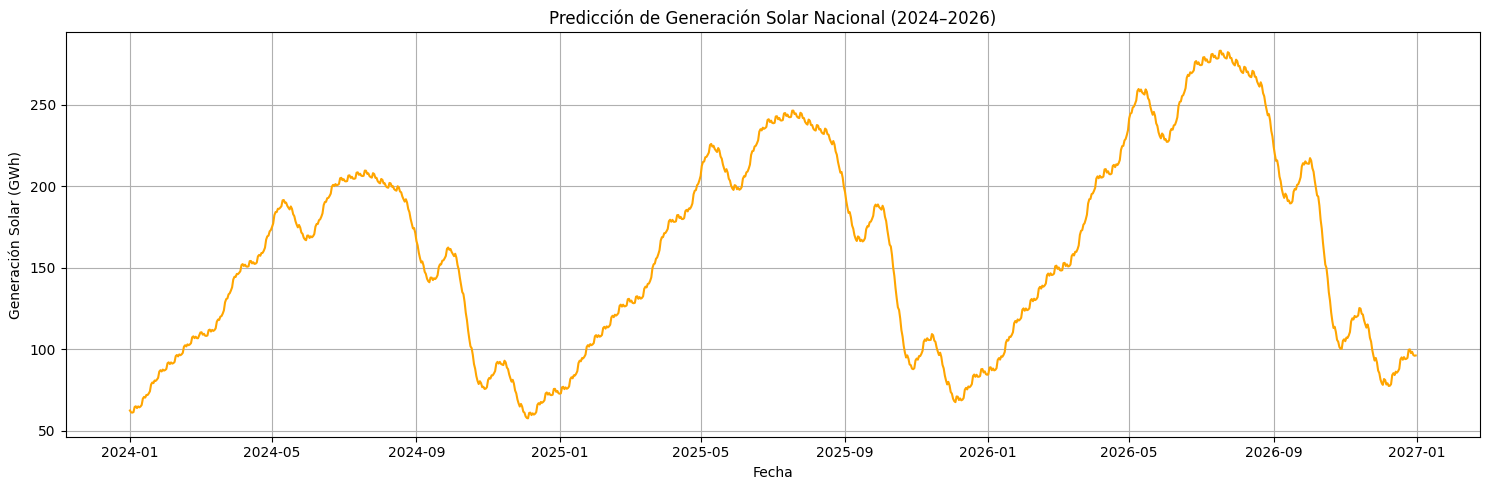

             ds       yhat  yhat_lower  yhat_upper
2910 2026-12-22  93.859926   71.155908  116.624455
2911 2026-12-23  94.031720   68.735304  117.068089
2912 2026-12-24  94.650402   71.660326  116.878733
2913 2026-12-25  99.581189   76.290325  124.618217
2914 2026-12-26  99.832028   77.263529  122.706987
2915 2026-12-27  97.522249   71.827430  120.326885
2916 2026-12-28  98.309443   74.360524  121.655475
2917 2026-12-29  96.351427   74.474756  118.592371
2918 2026-12-30  95.924312   71.451414  118.540572
2919 2026-12-31  96.094580   71.859174  119.989103

=== BASELINE ESTACIONAL ANUAL ===
MAE  : 26.371
RMSE : 33.166
WAPE : 32.76%

=== MODELO PROPHET ===
MAE (histórico): 14.17
RMSE (histórico): 18.2
WAPE: 15.65%

Guardado: pred_gen_solar_2024_2026.csv


['Modelo_Gen_Solar.joblib']

In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import joblib

# Cargamos los datos
df = pd.read_csv("../../SET_INPUTS_BASE_0.csv")

# Creaamos las columnas Year, Month y Day partiendo de la columna 'Date'
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

# Eliminamos 29 de febrero en años bisiestos (histórico)
df = df[~((df["Date"].dt.month == 2) & (df["Date"].dt.day == 29))].reset_index(drop=True)

# Visualización serie original 
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Gen_Solar_GWh"], label="Generación Solar (GWh)")
plt.xlabel("Fecha")
plt.ylabel("Generación Solar (GWh)")
plt.title("Generación Solar")
plt.legend()
plt.grid()
plt.show()

# Modificamos el formato para adaptarlo al requerido por Prophet
df_prophet = df.rename(columns={"Date": "ds", "Gen_Solar_GWh": "y"})[["ds", "y"]]


# Mejor modelo según las métricas analisadas anteriormente
model = Prophet(
    yearly_seasonality=True,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    interval_width=0.8
)
model.fit(df_prophet)

# Creaamos fechas futuras, todos los días 2024-2026 y luego eliminamos 29 de febrero
last_ds = df_prophet["ds"].max()
start_future = last_ds + pd.Timedelta(days=1)

future_dates = pd.date_range(start=start_future, end="2026-12-31", freq="D")
future_dates = future_dates[~((future_dates.month == 2) & (future_dates.day == 29))]
future_future = pd.DataFrame({"ds": future_dates})

# Construimos dataframe para predecir HISTÓRICO + FUTURO
future_all = pd.concat([df_prophet[["ds"]], future_future], ignore_index=True)
future_all = future_all.drop_duplicates().sort_values("ds")
future_all = future_all[~((future_all["ds"].dt.month == 2) & (future_all["ds"].dt.day == 29))]


# Predicción completa
forecast_all = model.predict(future_all)

# Gráfico de predicción histórico + futuro
fig = model.plot(forecast_all)
plt.title("Predicción de Generación Solar hasta 2026")
plt.xlabel("Fecha")
plt.ylabel("Gen_Solar_GWh")
plt.show()


# Subconjunto futuro 2024-2026
pred_3y = forecast_all[
    (forecast_all["ds"] >= "2024-01-01") &
    (forecast_all["ds"] <= "2026-12-31")
].copy()

# Pasamos al formato histórico
pred_3y["Year"]  = pred_3y["ds"].dt.year
pred_3y["Month"] = pred_3y["ds"].dt.month
pred_3y["Day"]   = pred_3y["ds"].dt.day
pred_3y["Gen_Solar_GWh"] = pred_3y["yhat"]

pred_3y_hist = pred_3y[["Year", "Month", "Day", "Gen_Solar_GWh"]]


# Gráfico de componentes del modelo Prophet
fig_components = model.plot_components(forecast_all)
plt.suptitle("Componentes del modelo Prophet", fontsize=16)
plt.show()

df["ds"] = pd.to_datetime(df["Date"])  # Aseguramos el tipo datetime y lo renombramos

# Extraemos datos reales y predicción del 2023
real_2023 = df[(df["ds"] >= "2023-01-01") & (df["ds"] <= "2023-12-31")].copy()
pred_2023 = forecast_all[(forecast_all["ds"] >= "2023-01-01") & (forecast_all["ds"] <= "2023-12-31")].copy()

# Unificamos predicción con datos reales
real_2023["yhat"] = pred_2023["yhat"].values

# Visualización real vs predicción 2023
plt.figure(figsize=(15, 5))
plt.plot(real_2023["ds"], real_2023["Gen_Solar_GWh"], label="Real", linewidth=2)
plt.plot(real_2023["ds"], real_2023["yhat"], label="Predicción", linewidth=2)
plt.title("Generación Solar Real vs Predicción (2023)")
plt.xlabel("Fecha")
plt.ylabel("Generación Solar (GWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Subconjunto futuro 2024-2026
pred_3y = forecast_all[
    (forecast_all["ds"] >= "2024-01-01") & 
    (forecast_all["ds"] <= "2026-12-31")
].copy()

# Gráfico de predicción 2024-2026
plt.figure(figsize=(15, 5))
plt.plot(pred_3y["ds"], pred_3y["yhat"], label="Predicción 2024–2026", color="orange")
plt.title("Predicción de Generación Solar Nacional (2024–2026)")
plt.xlabel("Fecha")
plt.ylabel("Generación Solar (GWh)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Tabla de predicción (últimas filas)
print(forecast_all[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(10))

# Métricas MAE y RMSE sobre histórico
pred_hist = forecast_all.merge(df_prophet, on="ds", how="inner")
mae = mean_absolute_error(pred_hist["y"], pred_hist["yhat"])
rmse = np.sqrt(mean_squared_error(pred_hist["y"], pred_hist["yhat"]))
wape = np.sum(np.abs(real_2023["Gen_Solar_GWh"] - real_2023["yhat"])) / np.sum(real_2023["Gen_Solar_GWh"])


# =====================================================
# BASELINE ESTACIONAL ANUAL (NAIVE)  ==================
# =====================================================

# Copiamos del dataframe original usado en el modelo
df_baseline = df.copy()

# Creamos fecha
df_baseline["ds"] = pd.to_datetime(df_baseline[["Year", "Month", "Day"]])

# Ordenamos por fechas
df_baseline = df_baseline.sort_values("ds").reset_index(drop=True)

# Baseline: mismo día del año anterior
df_baseline["baseline_naive_anual"] = df_baseline["Gen_Solar_GWh"].shift(365)

# Dataset válido
df_bl_eval = df_baseline.dropna(subset=["baseline_naive_anual"]).copy()

# Métricas
y_true = df_bl_eval["Gen_Solar_GWh"].values
y_pred = df_bl_eval["baseline_naive_anual"].values

baseline_mae = mean_absolute_error(y_true, y_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
baseline_wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

print("\n=== BASELINE ESTACIONAL ANUAL ===")
print(f"MAE  : {baseline_mae:.3f}")
print(f"RMSE : {baseline_rmse:.3f}")
print(f"WAPE : {baseline_wape:.2f}%")


print("\n=== MODELO PROPHET ===")
print("MAE (histórico):", round(mae, 2))
print("RMSE (histórico):", round(rmse, 2))
print(f"WAPE: {wape:.2%}")

pred_3y_hist.to_csv("pred_gen_solar_2024_2026.csv", index=False)
print("\nGuardado: pred_gen_solar_2024_2026.csv")



joblib.dump(model, "Modelo_Gen_Solar.joblib")
